In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from scipy.optimize import curve_fit
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [254]:
df = pd.read_csv("ZIKABR17.csv")
df['DT_NOTIFIC']

0        2017-04-01
1        2017-04-01
2        2017-04-01
3        2017-04-01
4        2017-04-01
            ...    
32679    2017-03-31
32680    2017-03-31
32681    2017-03-31
32682    2017-03-31
32683    2017-03-31
Name: DT_NOTIFIC, Length: 32684, dtype: object

In [255]:
df = df.groupby('DT_NOTIFIC').count().reset_index()
df.rename(columns={'DT_NOTIFIC':"Data", 'TP_NOT':'Casos'}, inplace= True)
df = df[['Data','Casos']]
df['Data'] = pd.to_datetime(df['Data'])

In [256]:
df.head()

,Data,Casos
0,2017-01-01,17
1,2017-01-02,98
2,2017-01-03,136
3,2017-01-04,130
4,2017-01-05,112


In [257]:
def plot_series(xaxis, yaxis, title):
  plt.figure(figsize=(15,4))
  plt.plot(xaxis, yaxis, color='tab:red')
  plt.gca().set(title=title, xlabel='Dia', ylabel='Quantidade de Casos')

  plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Format as "Month Year"

  plt.show()

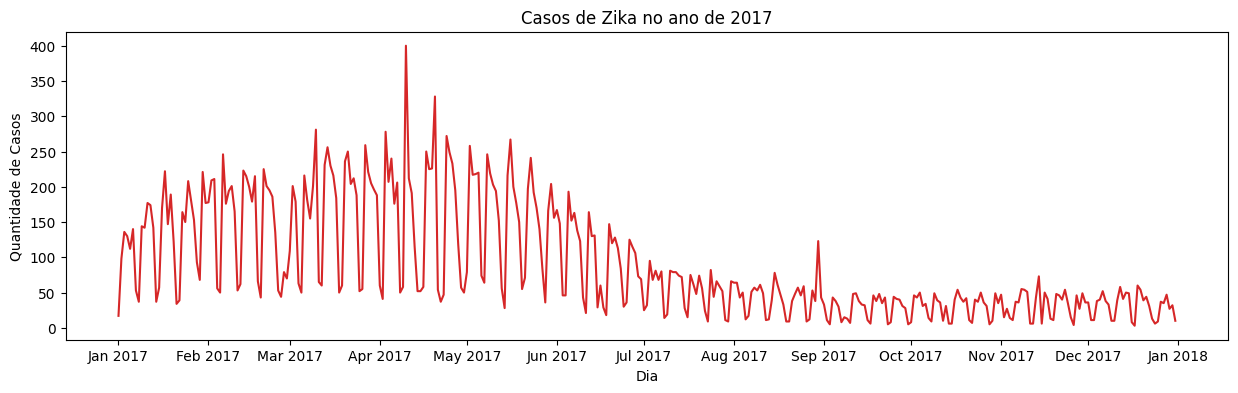

In [258]:
plot_series(df['Data'], df['Casos'], 'Casos de Zika no ano de 2017')

## Aplicando Transformações

### 1. Box-Cox Transformation

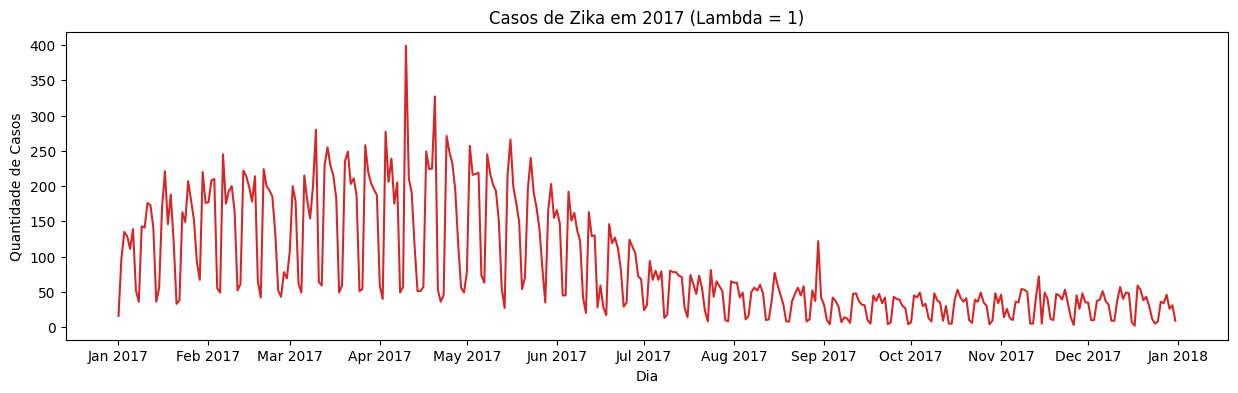

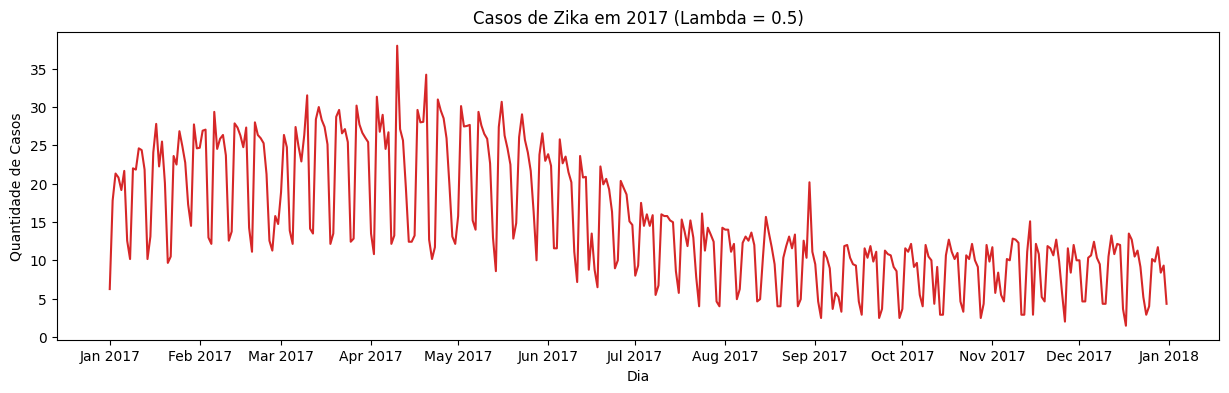

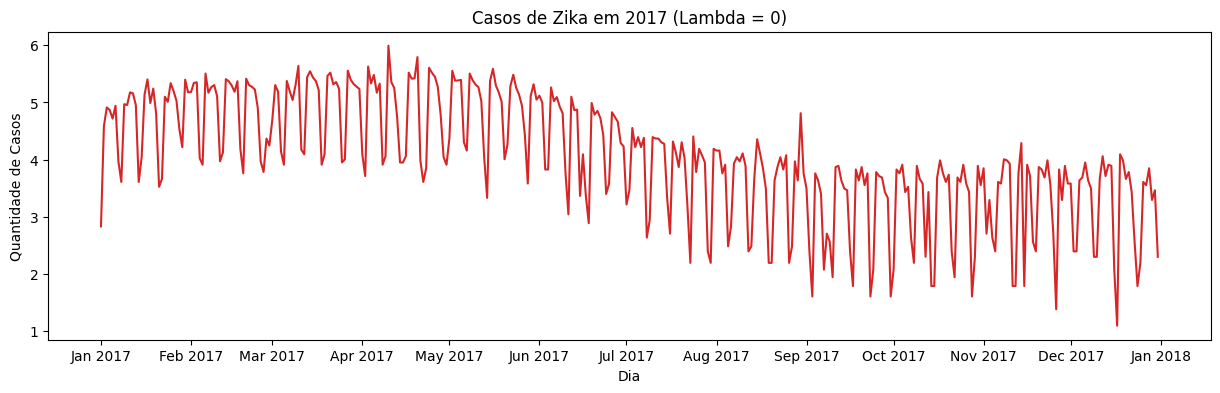

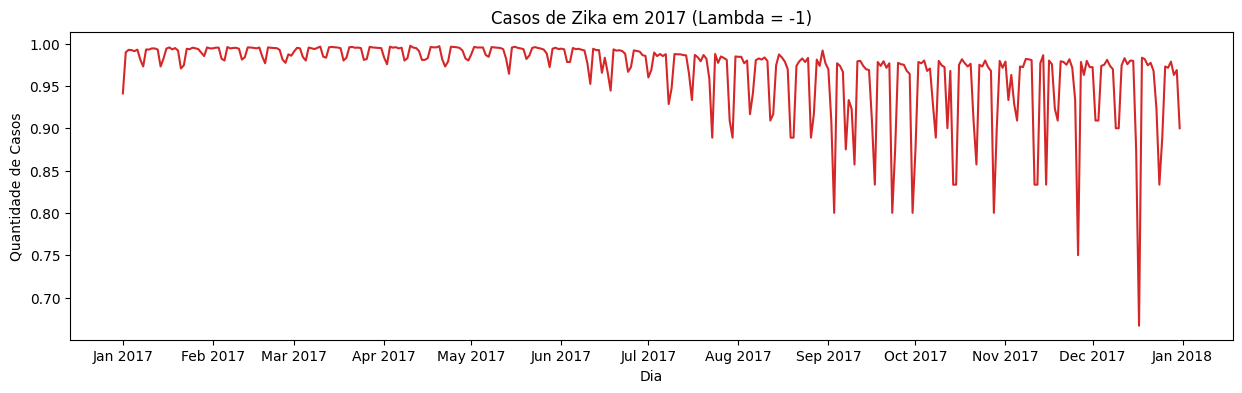

In [259]:
lambda_values = [1, 0.5, 0, -1]


for x in lambda_values:
  transformed_data = stats.boxcox(df['Casos'], lmbda = x)
  plot_series(df['Data'], transformed_data, f"Casos de Zika em 2017 (Lambda = {x})")

### 2. Lidando com Tendências

#### 2.1 Ajuste de Curvas

In [260]:
df['Data']

0     2017-01-01
1     2017-01-02
2     2017-01-03
3     2017-01-04
4     2017-01-05
         ...    
360   2017-12-27
361   2017-12-28
362   2017-12-29
363   2017-12-30
364   2017-12-31
Name: Data, Length: 365, dtype: datetime64[ns]

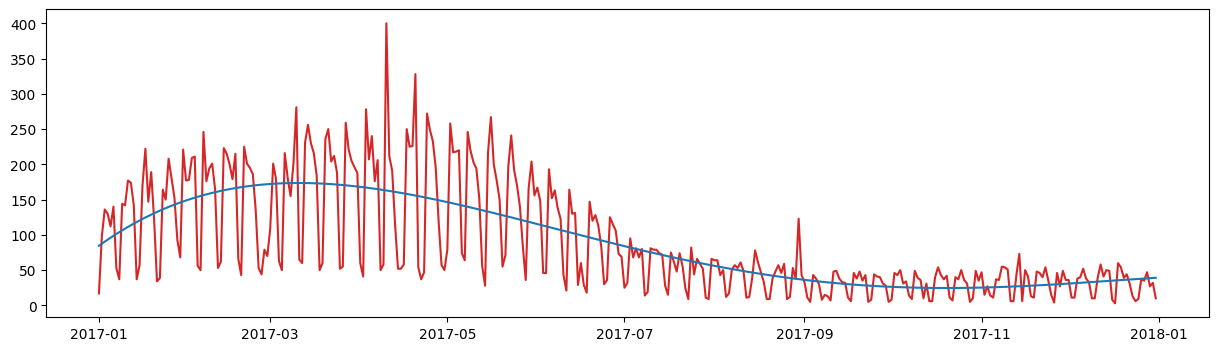

In [261]:
lista = np.array(list(range(1,366)))

X = np.column_stack(lista)
X = X.reshape([365,1])

Xm = X ** np.arange(0,5)

model = sm.OLS(df['Casos'],Xm)
results = model.fit()

fitted_curve = results.predict(Xm)
# model = sm.OLS(dados_curva['y'], dados_curva[['const', 'x', 'x**2']]).fit()

# params = model.params

# fitted_curve = params['const'] + params['x'] * x + params['x**2'] * x**2


plt.figure(figsize=(15,4))

plt.plot(df['Data'],df['Casos'],'tab:red')
plt.plot(df['Data'],fitted_curve,'-')
plt.show()

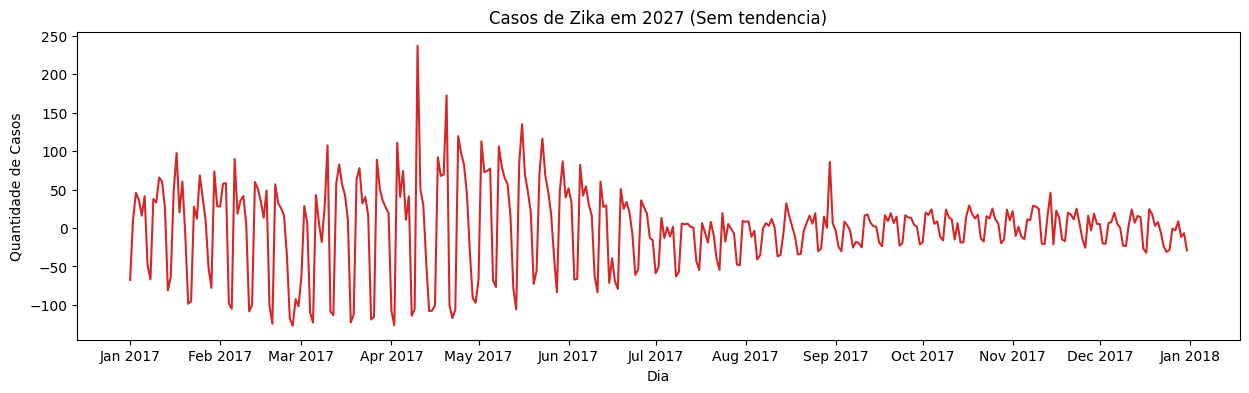

In [262]:
sem_tendencia = df['Casos'].copy() - fitted_curve
plot_series(df['Data'], sem_tendencia, 'Casos de Zika em 2027 (Sem tendencia)')

#### 2.2 Filtro Linear

In [263]:
def filtro_linear(series, k):

  # Calculate the means between adjacent values with the specified window size
  weights = np.ones(k) / k
  return(pd.Series(np.convolve(series, weights, mode='valid')))

<Figure size 1500x400 with 0 Axes>

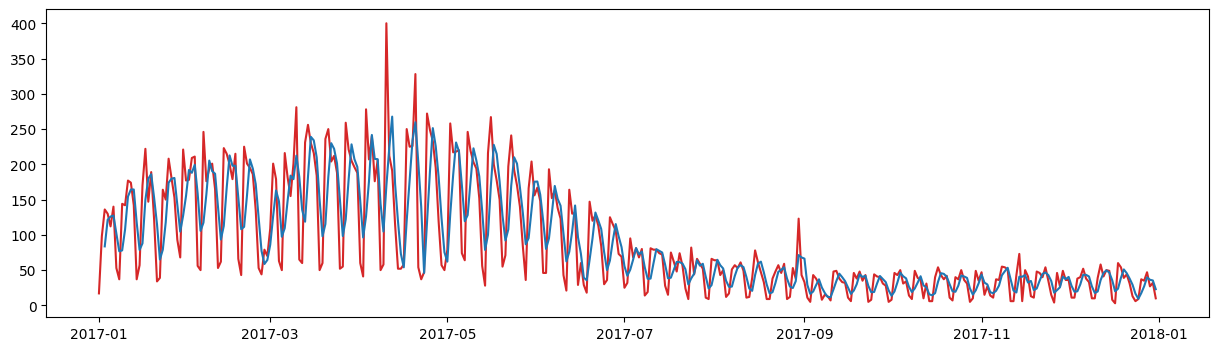

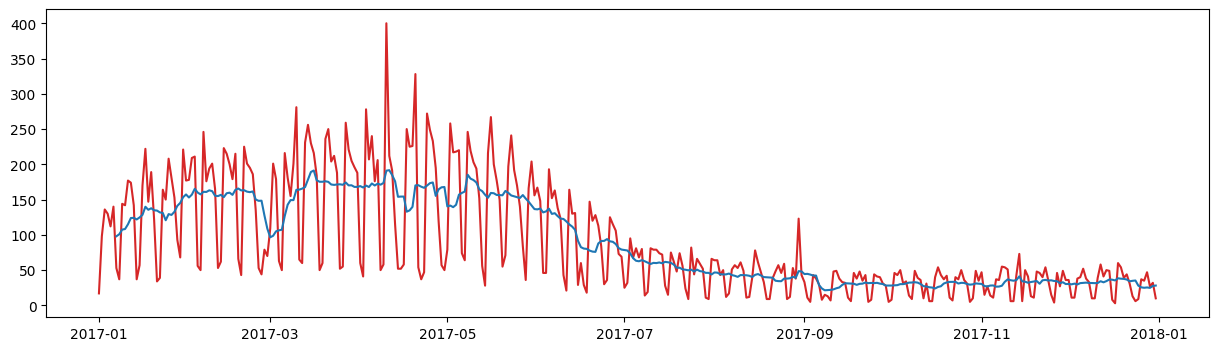

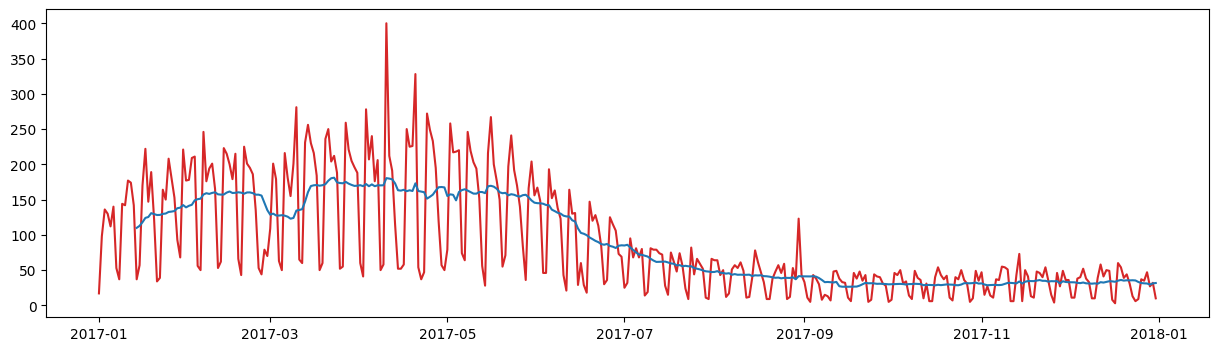

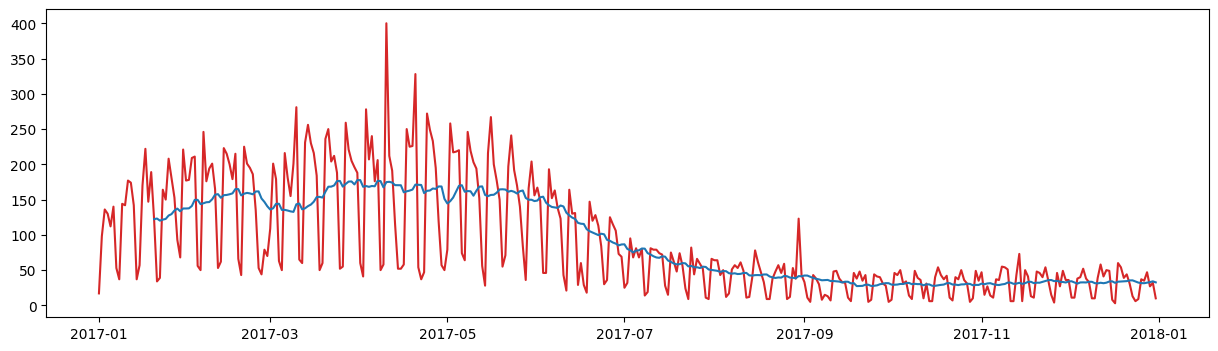

In [264]:
plt.figure(figsize=(15,4))
k_list = [3, 7, 14,20]

for x in k_list:
  plt.figure(figsize=(15,4))
  filtrado = filtro_linear(df['Casos'].copy(), x)
  plt.plot(list(df['Data']),df['Casos'],'tab:red')
  plt.plot(list(df['Data'])[(x-1):],filtrado,'-')
  plt.show()

#### 2.3 Diferenciação

In [265]:
def diferenciacao_1_ordem(series):
  return(pd.Series(np.diff(series)))

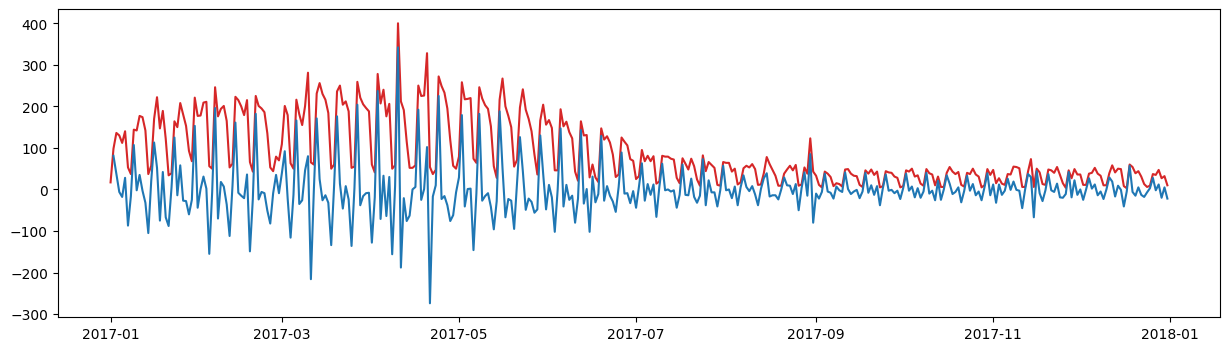

In [266]:
  plt.figure(figsize=(15,4))
  filtrado = filtro_linear(df['Casos'].copy(), x)
  plt.plot(list(df['Data']),df['Casos'],'tab:red')
  plt.plot(list(df['Data'])[1:],diferenciacao_1_ordem(df['Casos']),'-')
  plt.show()

In [267]:
def diferenciacao_sazonal(series, k):
  return pd.Series(series[k-1:] - series[:-(k-1)])

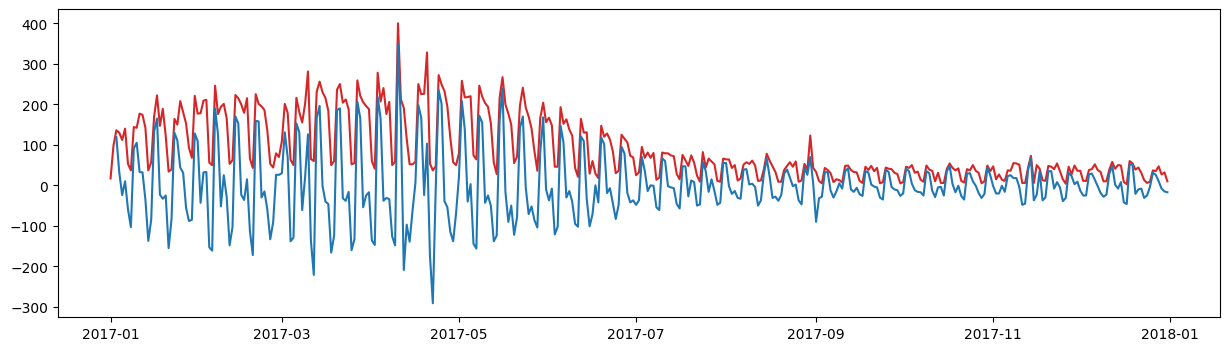

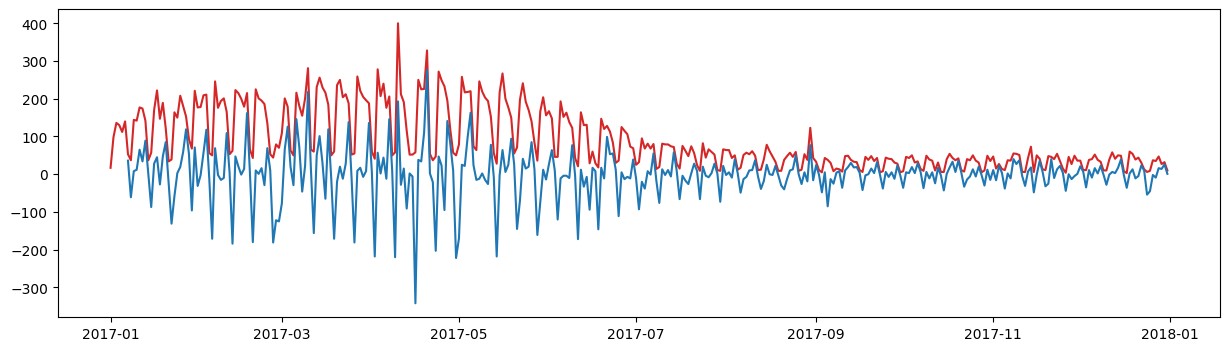

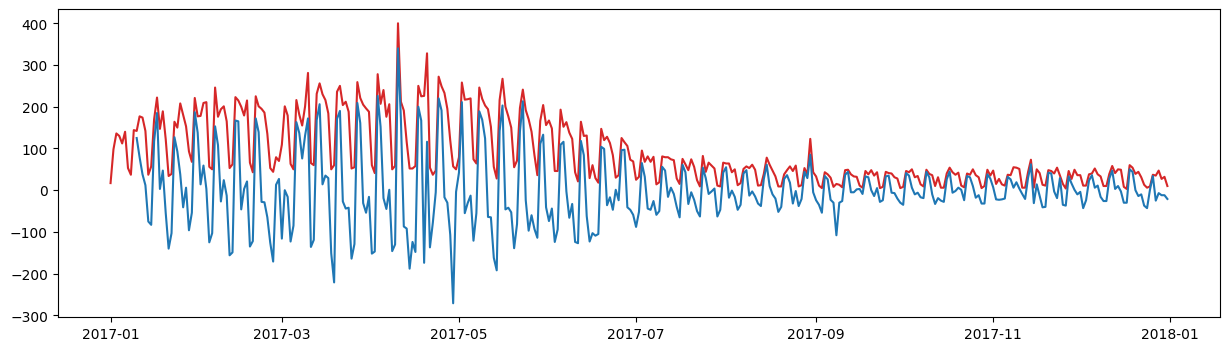

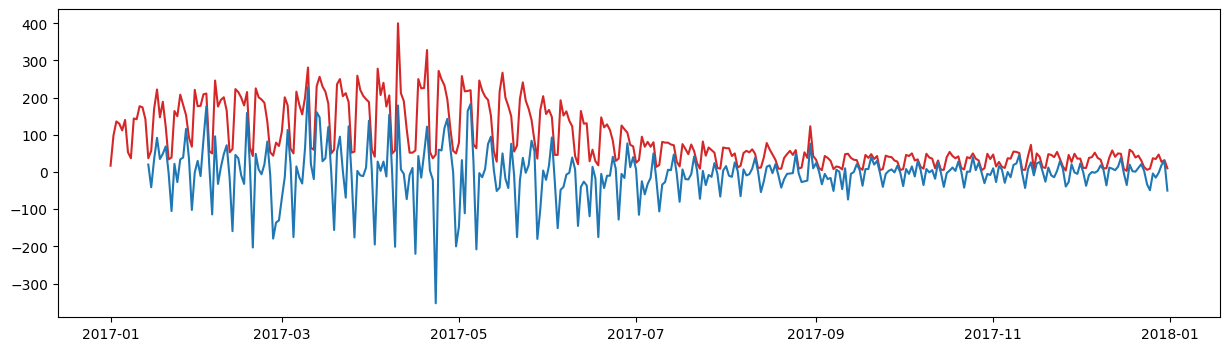

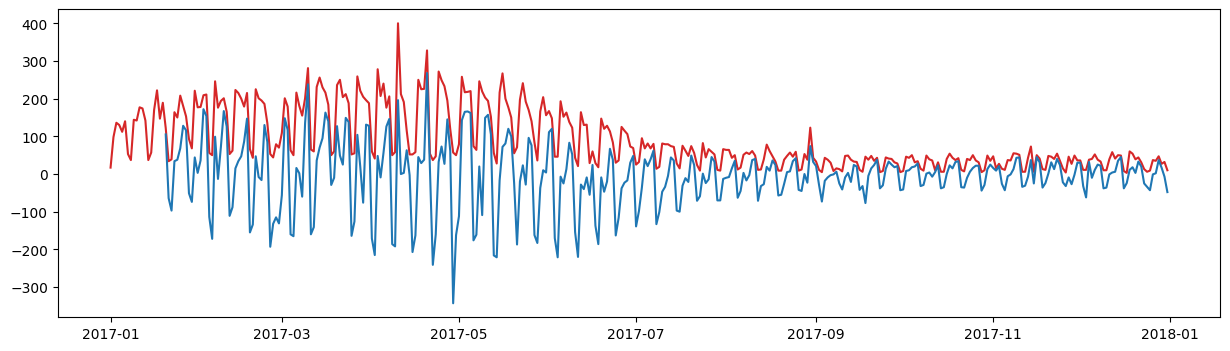

In [268]:
k_list = [3, 7, 10, 14, 20]

for x in k_list:
  plt.figure(figsize=(15,4))
  diferenciado = diferenciacao_sazonal(np.array((df['Casos'].copy())),x)
  plt.plot(list(df['Data']),df['Casos'],'tab:red')
  plt.plot(list(df['Data'])[x-1:],diferenciado,'-')
  plt.show()

### 3. Correlograma

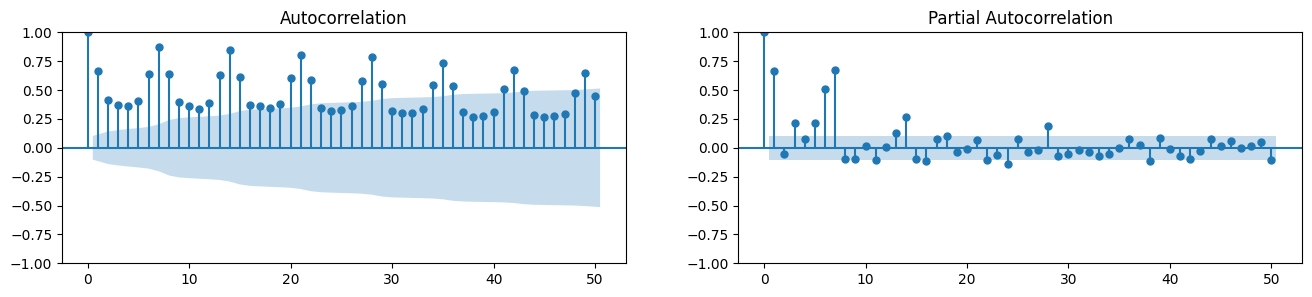

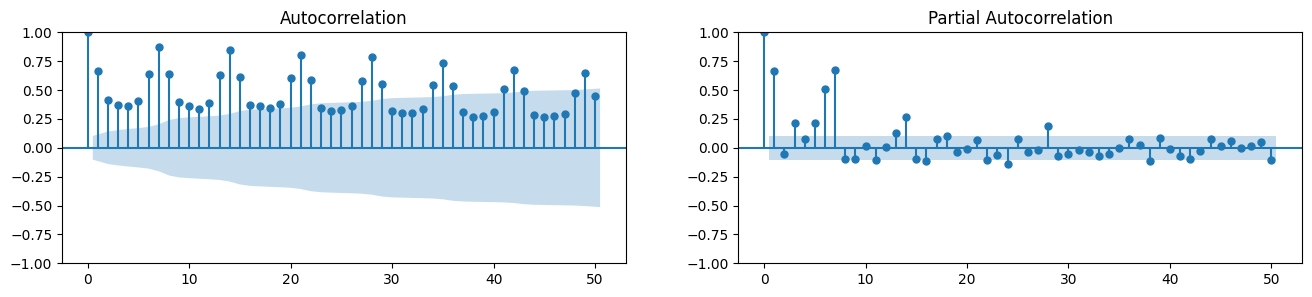

In [271]:
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Casos'].tolist(), lags=50, ax=axes[0])
plot_pacf(df['Casos'].tolist(), lags=50, ax=axes[1])